<a href="https://colab.research.google.com/github/elinteerie/Models/blob/main/Building_SkimLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

Build an NLP Model to make reading medical abstracts easier

### Confirm Access to a GPU

In [1]:
!nvidia-smi -L


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



###Get Data



In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
#Check All the file names

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames[0]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'

###Preprocess Data

In [6]:
def get_lines(filename):
  '''
  Reads Filename (a text file ) and returns the lines of text as a list

  Args:
  filename: a string containin the target filepath
  
  Returns: A list of strings with one string per line from the target filename
  '''
  with open(filename, 'r') as f:
    return f.readlines()




In [7]:
train_lines = get_lines(filenames[0])

In [8]:
train_lines[:2]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n']

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[2])

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df =pd.DataFrame(test_samples)

In [12]:
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [13]:
train_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

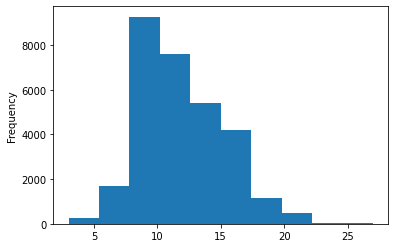

In [14]:
train_df.total_lines.plot.hist();

In [15]:
train_sentences = train_df['text'].tolist()
val_sentences =val_df['text'].tolist()
test_sentences =test_df['text'].tolist()

len(train_sentences)

30135

In [16]:
train_sentences[:10]


['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

### Making Numerical Labels



In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse =False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df[['target']].to_numpy())
val_labels_one_hot = one_hot_encoder.fit_transform(val_df[['target']].to_numpy())
test_label_one_hot =one_hot_encoder.fit_transform(test_df[['target']].to_numpy())



In [18]:
test_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
###Encode Labels

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df[['target']].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df[['target']].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df[['target']].to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
train_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [22]:
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [23]:
###Get the Class
label_encoder.classes_



array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [24]:
###Starting With serie of Modelling Experiments

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [25]:
##Create a pipleline

model_0 = Pipeline([
     ('tf-idf', TfidfVectorizer()),
      ('clf', MultinomialNB())               
])

#fit 

model_0.fit(train_sentences, train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
#Evalaute

model_0.score(X =val_sentences, y= val_labels_encoded)

0.6760889712696941

In [27]:
#Make Predictions

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 2, ..., 4, 4, 0])

In [28]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [29]:
!wget https://raw.githubusercontent.com/elinteerie/Extra/main/helper_functions.py

--2022-07-04 20:06:35--  https://raw.githubusercontent.com/elinteerie/Extra/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14389 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.05K  --.-KB/s    in 0.001s  

2022-07-04 20:06:35 (26.9 MB/s) - ‘helper_functions.py’ saved [14389/14389]



In [30]:
from helper_functions import *

In [31]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)

In [32]:
baseline_results

{'accuracy': 67.60889712696941,
 'f1': 0.6351051244365337,
 'precision': 0.6750509747444058,
 'recall': 0.6760889712696941}

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [34]:
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)

In [35]:
round(avg_sent_len)

26

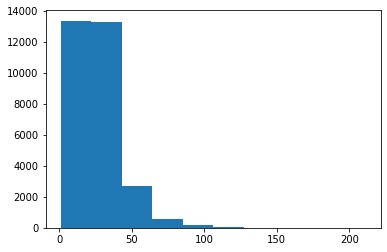

In [36]:
import matplotlib.pyplot as plt
plt.hist(sent_len);

In [37]:
#How long is the Sentence
output_seq_len = int(np.percentile(sent_len, 95))

In [38]:
output_seq_len 

55

In [39]:
max(sent_len)

211

In [40]:
max_tokens = 68000

In [41]:
#### Using Deep Sequence

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                                    ngrams=1,
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [42]:
import random
target_sentence = random.choice(train_sentences)

In [43]:
target_sentence

'dual therapy with lopinavir and ritonavir plus lamivudine regimen warrants further clinical research and consideration as a potential therapeutic option for antiretroviral-therapy-naive patients .'

In [44]:
text_vectorizer.adapt(train_sentences)

In [45]:
test = text_vectorizer(target_sentence)

In [46]:
test = tf.expand_dims(test, axis =0)

In [47]:
rct_20k = text_vectorizer.get_vocabulary()
len(rct_20k)

24854

In [48]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': 1,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [49]:
token_embed = layers.Embedding(input_dim=68000, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [50]:
em = token_embed(test)

In [51]:
print(em.shape)

(1, 55, 128)


In [52]:
#train_sentences = tf.expand_dims(train_sentences, axis =0)
#val_sentences = tf.expand_dims(val_sentences, axis =0)
#test_sentences = tf.expand_dims(test_sentences, axis =0)



# Create a Dataset With Tf Dataset

In [53]:
train_dataset =  tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

In [54]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [55]:
train_dataset

list(train_dataset.as_numpy_iterator())

[(b'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  array([1., 0., 0., 0., 0.])),
 (b'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  array([0., 0., 0., 0., 1.])),
 (b'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  array([0., 0., 0., 0., 1.])),
 (b'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
  array([0., 0., 0., 0., 1.])),
 (b"the percentage of patients with abnormal lfts decrease

In [56]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [57]:
#Turn to Prefetch 
AUTO_TUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(32).prefetch(buffer_size=AUTO_TUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=AUTO_TUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=AUTO_TUNE)

In [58]:
### Build Model Conv1D
inputs = layers.Input(shape =(1,), dtype =tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
print(x.shape)
x = layers.Conv1D(64, 5, padding ='same' , activation ='relu')(x)
x= layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation ='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

(None, 55, 128)


In [59]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [60]:
model_1.compile(loss ='categorical_crossentropy', 
                optimizer =tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

In [61]:
model_1_history = model_1.fit(train_dataset, epochs = 3,
                              validation_data = val_dataset)

Epoch 1/3
942/942 [==============================] - 178s 188ms/step - loss: 0.8259 - accuracy: 0.6780 - val_loss: 0.6415 - val_accuracy: 0.7564
Epoch 2/3
942/942 [==============================] - 183s 194ms/step - loss: 0.5048 - accuracy: 0.8214 - val_loss: 0.6409 - val_accuracy: 0.7704
Epoch 3/3
942/942 [==============================] - 186s 198ms/step - loss: 0.3535 - accuracy: 0.8818 - val_loss: 0.7164 - val_accuracy: 0.7620


In [62]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(val_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.7164 - accuracy: 0.7620


[0.7163839936256409, 0.7620481848716736]

In [63]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[8.3902341e-01, 1.9360824e-02, 3.7399069e-03, 1.3766944e-01,
        2.0631420e-04],
       [6.6860074e-01, 2.2858277e-01, 6.3722222e-03, 9.5502451e-02,
        9.4176154e-04],
       [2.3421359e-01, 9.7006495e-04, 3.2114721e-04, 7.6449496e-01,
        2.7626578e-07],
       ...,
       [2.0086601e-08, 2.1755563e-05, 2.3648117e-05, 1.3513752e-08,
        9.9995458e-01],
       [6.2154610e-02, 8.2826734e-01, 5.4592132e-03, 1.0771980e-02,
        9.3346849e-02],
       [4.7392860e-02, 9.4345695e-01, 5.9873704e-03, 1.2363724e-03,
        1.9263339e-03]], dtype=float32)

In [64]:
model_1_preds = tf.argmax(model_1_pred_probs, axis =1)

In [65]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [66]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.20481927710844,
 'f1': 0.7588897929965169,
 'precision': 0.7631493023120532,
 'recall': 0.7620481927710844}

### Using a USE Model_2

In [67]:
import tensorflow_hub as hub
use_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable =False, name ='Use_embed')

In [68]:
random_train_sent = random.choice(train_sentences)

In [69]:
random_train_sent

'the yin-yang meridians acupuncture with respiratry reinforcing and re - ducing manipulation effectively improves the lower limbs balance function in the patients of stroke .'

In [70]:
use_embed([random_train_sent])


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.04348128, -0.03890184,  0.00439691, -0.04747997, -0.01706989,
         0.01232149, -0.0187826 ,  0.00324459, -0.03724534,  0.04492866,
         0.08542679, -0.06724378,  0.03978226,  0.04163681,  0.07702196,
         0.0260667 , -0.08662151, -0.03650858, -0.02661335,  0.05844988,
        -0.03457608,  0.07561877, -0.03197628,  0.00828649,  0.0685629 ,
        -0.01738249, -0.07946834,  0.02412452, -0.01366428,  0.04727173,
        -0.00297098,  0.08864304,  0.04827178,  0.03435268,  0.0776463 ,
         0.02903014, -0.00613191,  0.07867915, -0.06007094, -0.07457617,
        -0.00477917,  0.00680803,  0.04674504, -0.04646059, -0.01346927,
         0.01829705,  0.03745835,  0.06350207,  0.02305653, -0.01374148,
        -0.05256437, -0.01520659, -0.00460277,  0.05267237,  0.06975814,
         0.00060239,  0.00517513, -0.02710582,  0.05729758, -0.04393926,
        -0.00378087,  0.0558951 ,  0.01450007,  0.06687282, -0.01048769,
 

In [71]:
##Building a Model_2

inputs = layers.Input(shape =[], dtype = tf.string)
x = use_embed(inputs)
x =layers.Dense(128, activation ='relu')(x)
#x = layers.Conv1D(64, 5, padding='same')(x)
outputs = layers.Dense(5, activation ='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)





In [72]:
model_2.compile(loss ='categorical_crossentropy', 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [73]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Use_embed (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
history_model_2 = model_2.fit(train_dataset, epochs =3,
                              validation_data = val_dataset,
                              steps_per_epoch =int(0.1*len(train_dataset)),
                              validation_steps =int(0.1*len(val_dataset)))

Epoch 1/3
94/94 [==============================] - 10s 43ms/step - loss: 1.2513 - accuracy: 0.5196 - val_loss: 1.0211 - val_accuracy: 0.6031
Epoch 2/3
94/94 [==============================] - 2s 23ms/step - loss: 0.9244 - accuracy: 0.6353 - val_loss: 0.8672 - val_accuracy: 0.6682
Epoch 3/3
94/94 [==============================] - 2s 23ms/step - loss: 0.8686 - accuracy: 0.6702 - val_loss: 0.8263 - val_accuracy: 0.6769


In [75]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.8288 - accuracy: 0.6792


[0.8287917971611023, 0.6791672110557556]

In [76]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[0.5330349 , 0.30478165, 0.01557862, 0.11649297, 0.03011179],
       [0.40139666, 0.47380444, 0.01243163, 0.09623123, 0.0161361 ],
       [0.3482466 , 0.26802188, 0.04628678, 0.25320148, 0.08424324],
       ...,
       [0.00449865, 0.00509781, 0.15461285, 0.00195625, 0.83383447],
       [0.01154303, 0.03159938, 0.2557583 , 0.00387633, 0.69722295],
       [0.18334097, 0.101136  , 0.5366366 , 0.03512747, 0.14375895]],
      dtype=float32)

In [77]:
model_2_preds = tf.argmax(model_2_pred_probs, axis =1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 2])>

In [78]:
model_2_result = calculate_results(val_labels_encoded, model_2_preds)

In [79]:
model_2_result

{'accuracy': 67.91672183238448,
 'f1': 0.6715109536900726,
 'precision': 0.6769299487976713,
 'recall': 0.6791672183238449}

###Model 3 with Character level embedding 

In [80]:
#Splitting text into characters level

def split_chars(text):
  return ' '.join(list(text))


In [81]:
#Split Sequence-lebel data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [82]:
train_chars[:5]

['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .',
 'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .',
 'l i v e r   f u n c t i o n   t e s t s   (   l f t s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 's u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

In [83]:
## Average Character length

chars_lens = [len(sentence) for sentence in train_sentences ]
mean_char_len = np.mean(chars_lens)

In [84]:
mean_char_len

148.45996349759415

(array([6.6630e+03, 1.4759e+04, 6.5500e+03, 1.5780e+03, 4.1500e+02,
        1.1300e+02, 3.5000e+01, 1.3000e+01, 6.0000e+00, 3.0000e+00]),
 array([  2. ,  89.7, 177.4, 265.1, 352.8, 440.5, 528.2, 615.9, 703.6,
        791.3, 879. ]),
 <a list of 10 Patch objects>)

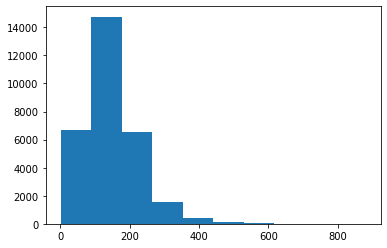

In [85]:
## 
plt.hist(chars_lens)

In [86]:
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

288

In [87]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKEN = len(alphabet) +2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                                    output_sequence_length = output_seq_char_len,
                                                    #standardize = None,
                                                    name ='char_vectorizer'
                                                    )

In [88]:
char_vectorizer.adapt(train_chars)

In [89]:
char_vocab = char_vectorizer.get_vocabulary()

In [90]:
len(char_vocab)

28

In [91]:
char_vocab[:5]

['', '[UNK]', 'e', 't', 'i']

In [92]:
char_vocab[-5:]

['k', 'x', 'z', 'q', 'j']

In [93]:
random_train_chars = random.choice(train_chars)
randoo =char_vectorizer(random_train_chars)


### Character level embed

In [94]:
char_embedding = tf.keras.layers.Embedding(input_dim =len(char_vocab),
                                           output_dim =25,
                                           mask_zero = True

                                           )

In [95]:
#Test out
char_embedding(randoo)

<tf.Tensor: shape=(288, 25), dtype=float32, numpy=
array([[-0.04041554,  0.04675544,  0.03128755, ...,  0.02658336,
         0.02262304,  0.03249471],
       [-0.00151247,  0.02606431,  0.02850557, ..., -0.03078065,
        -0.03447927, -0.04229099],
       [ 0.00187992, -0.01659578, -0.0487553 , ..., -0.02205653,
         0.04083346,  0.01642967],
       ...,
       [-0.00509045, -0.02994628,  0.03912196, ..., -0.00584321,
        -0.04814612,  0.02137313],
       [-0.00509045, -0.02994628,  0.03912196, ..., -0.00584321,
        -0.04814612,  0.02137313],
       [-0.00509045, -0.02994628,  0.03912196, ..., -0.00584321,
        -0.04814612,  0.02137313]], dtype=float32)>

In [96]:
## Building a Model for model_3

inputs = layers.Input(shape = (1,), dtype = tf.string)

x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding ='same', activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)
model_3= tf.keras.Model(inputs, outputs)

In [97]:
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

In [98]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 288)              0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 288, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 288, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [99]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_encoded)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [100]:
history_model_3 = model_3.fit(train_char_dataset, epochs = 5,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1* len(val_char_dataset))
                              )

Epoch 1/5
94/94 [==============================] - 4s 35ms/step - loss: 1.4669 - accuracy: 0.3637 - val_loss: 1.4389 - val_accuracy: 0.3577
Epoch 2/5
94/94 [==============================] - 3s 33ms/step - loss: 1.4032 - accuracy: 0.4538 - val_loss: 1.3581 - val_accuracy: 0.4801
Epoch 3/5
94/94 [==============================] - 3s 31ms/step - loss: 1.3136 - accuracy: 0.4807 - val_loss: 1.2226 - val_accuracy: 0.5100
Epoch 4/5
94/94 [==============================] - 3s 31ms/step - loss: 1.1957 - accuracy: 0.5123 - val_loss: 1.1297 - val_accuracy: 0.5485
Epoch 5/5
94/94 [==============================] - 3s 31ms/step - loss: 1.1028 - accuracy: 0.5565 - val_loss: 1.0765 - val_accuracy: 0.5635


In [101]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred = tf.argmax(model_3_pred_probs, axis =1)

In [102]:
model_3_results = calculate_results(val_labels_encoded, model_3_pred)

In [103]:
model_3_results

{'accuracy': 56.99390970475308,
 'f1': 0.5385296942383837,
 'precision': 0.5754919363397666,
 'recall': 0.5699390970475308}

## Model To take Multi Inputs of Data

In [104]:
token_inputs = layers.Input(shape=[], dtype = tf.string, name ="token_input")
token_embedding = use_embed(token_inputs)
token_ouput = layers.Dense(128, activation ='relu')(token_embedding)

token_model = tf.keras.Model(token_inputs,token_ouput )


In [105]:
char_inputs = layers.Input(shape =(1,), dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_emb = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_emb)
char_model = tf.keras.Model(inputs = char_inputs, outputs =char_bi_lstm)


In [106]:
# Concatenate

token_char_concat = layers.Concatenate(name ='token_char_hybrd')([token_model.output,
                                                                 char_model.output])

In [107]:
# Create output layers

combine_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combine_dropout)
final_dropuout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation ='softmax')(final_dropuout)
model_4 = tf.keras.Model(inputs =[token_model.input, char_model.input], outputs = output_layer)

In [108]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 288)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 Use_embed (KerasLayer)         (None, 512)          256797824   ['token_input[0][0]']      

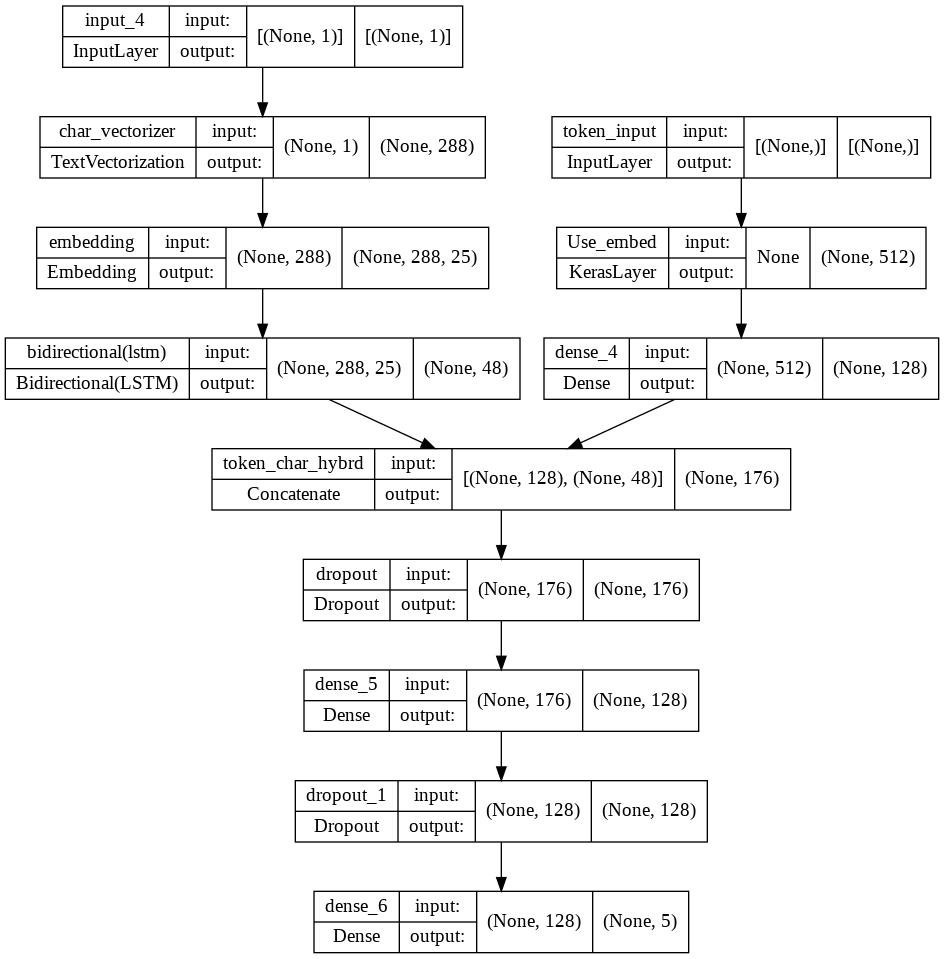

In [109]:
##Plot Hybrid Model

tf.keras.utils.plot_model(model_4, show_shapes=True)



In [110]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )

In [111]:
### Combining 
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset  =  tf.data.Dataset.zip((train_char_token_data, train_char_token_label))
train_char_token_dataset =train_char_token_dataset.batch(32).prefetch(buffer_size =tf.data.AUTOTUNE)

In [112]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_label))

val_char_token_dataset =val_char_token_dataset.batch(32).prefetch(buffer_size =tf.data.AUTOTUNE)

In [113]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [114]:
history_model_4 = model_4.fit(train_char_token_dataset, 
                              epochs = 5,
                              validation_data = val_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              validation_steps = int( 0.1 * len(val_char_token_dataset))
                              )

Epoch 1/5
94/94 [==============================] - 52s 437ms/step - loss: 1.3249 - accuracy: 0.4451 - val_loss: 1.0552 - val_accuracy: 0.5595
Epoch 2/5
94/94 [==============================] - 36s 388ms/step - loss: 1.0153 - accuracy: 0.5884 - val_loss: 0.9020 - val_accuracy: 0.6456
Epoch 3/5
94/94 [==============================] - 37s 390ms/step - loss: 0.9480 - accuracy: 0.6223 - val_loss: 0.8493 - val_accuracy: 0.6652
Epoch 4/5
94/94 [==============================] - 37s 399ms/step - loss: 0.8980 - accuracy: 0.6516 - val_loss: 0.8191 - val_accuracy: 0.6749
Epoch 5/5
94/94 [==============================] - 36s 386ms/step - loss: 0.8871 - accuracy: 0.6599 - val_loss: 0.7936 - val_accuracy: 0.7008


In [115]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 63s 67ms/step - loss: 0.7949 - accuracy: 0.6975


[0.7949314713478088, 0.6975042819976807]

In [116]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)

In [119]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds )
model_4_results

{'accuracy': 69.75043029259896,
 'f1': 0.6907116317447155,
 'precision': 0.6896193250608255,
 'recall': 0.6975043029259896}

## Transfer Learning with Fearure Engineering / Positional Embedding





In [120]:
### How many Different number

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [127]:
#Use Tensorflow to Create One_hot
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

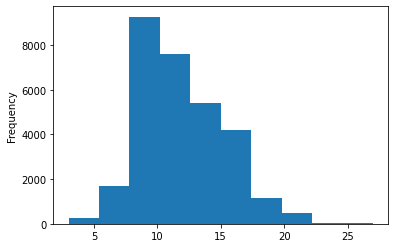

In [129]:
train_df.total_lines.plot.hist()

In [133]:
#Use Tensorflow to Create One_hot
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)


TensorShape([30135, 20])

In [136]:
train_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


### Building A Tripid 

In [140]:
token_inputs = layers.Input(shape =[], dtype = tf.string, name ='token_inputs')
token_embedding = use_embed(token_inputs)
token_outputs = layers.Dense(128, activation ='relu')(token_embedding)
token_model = tf.keras.Model(inputs =token_inputs, outputs =token_outputs)

In [142]:
char_inputs = layers.Input(shape =(1,), dtype = tf.string, name ='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs = char_inputs, outputs =char_bi_lstm)

In [149]:
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32,name ='line_number_inputs')
line_number_dense = layers.Dense(32, activation ='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs = line_number_dense )

In [151]:
total_line_inputs = layers.Input(shape =(20, ), dtype = tf.float32, name = 'total_line_inp')
total_line_dense = layers.Dense(32, activation ='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs= total_line_inputs, outputs =total_line_dense )

In [156]:
#Combine 

combined_embedding = layers.Concatenate(name='char_token_combined')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embedding)
z = layers.Dropout(0.5)(z)

In [157]:
#Combined with Positional
tripid_embeddings = layers.Concatenate(name ='tripid_embed')([line_number_model.output,
                                                              total_line_model.output,
                                                              z

                                                              ])

In [158]:
# Create Output layer

output_layer = layers.Dense(5, activation ='softmax', name ='output_layer')(tripid_embeddings)

In [159]:
#Put together

model_5 = tf.keras.Model(inputs =[line_number_model.input, 
                                  total_line_model.input, 
                                  token_model.input,
                                  char_model.input], outputs =output_layer,
                         name ='tripid_model'
                          )

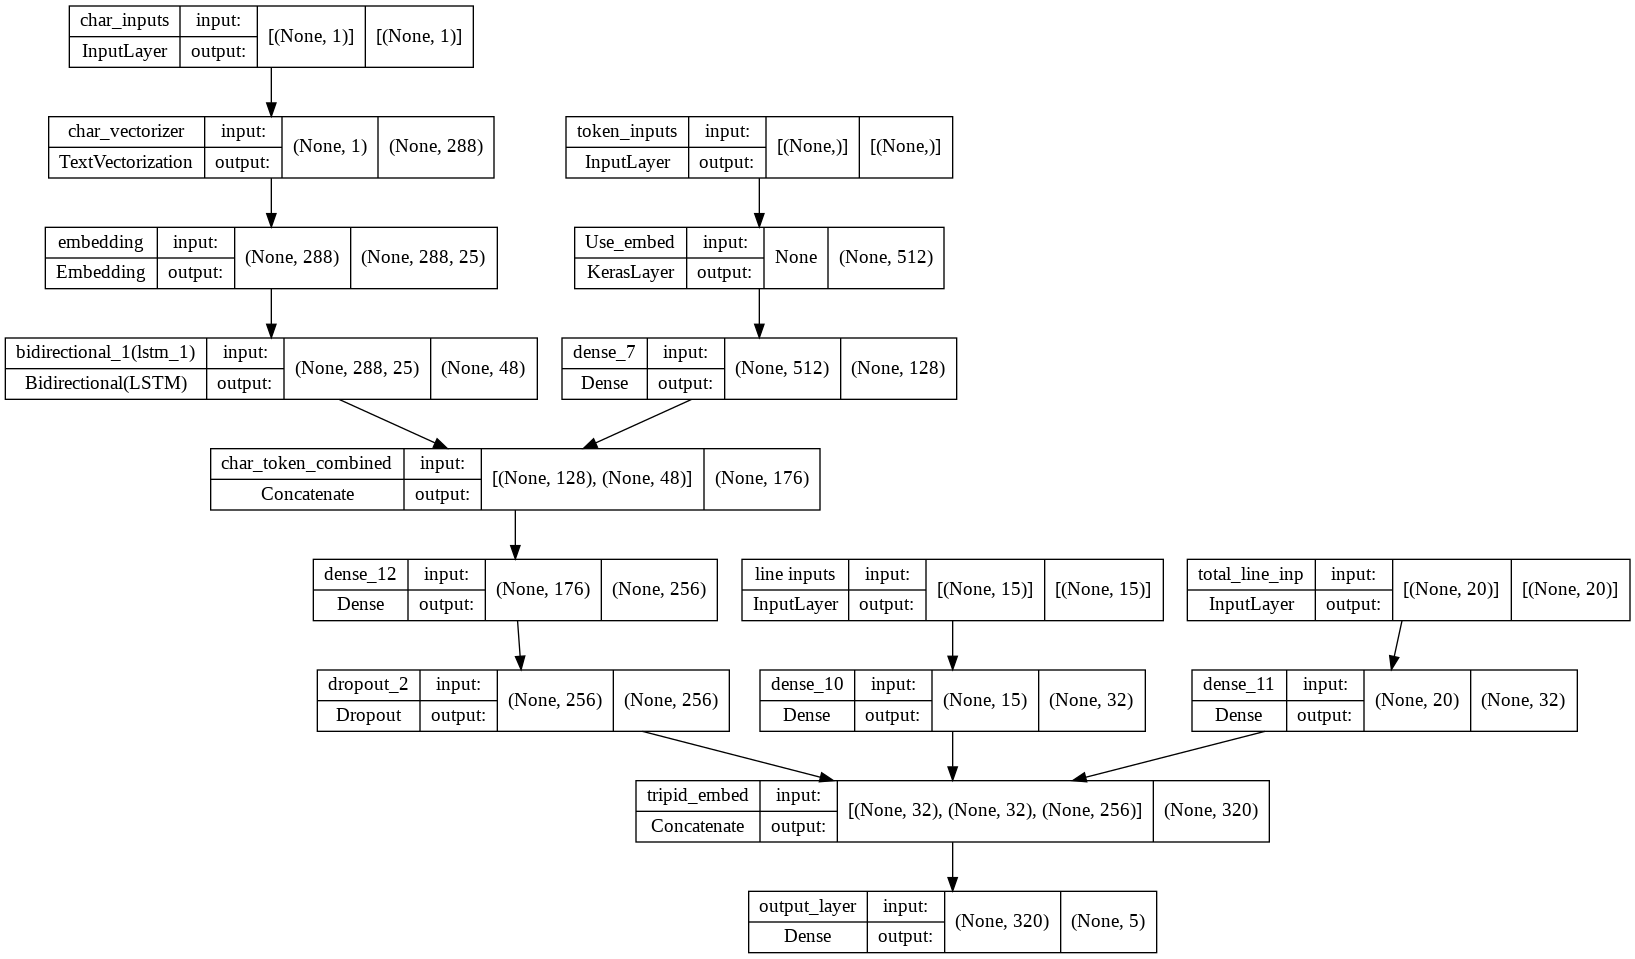

In [163]:
tf.keras.utils.plot_model(
    model_5,show_shapes=True)

In [164]:
model_5.summary()

Model: "tripid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 288)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 Use_embed (KerasLayer)         (None, 512)          256797824   ['token_inputs[0][0]']

In [170]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [165]:
#Create A Tribrid Pipeline wth 4 



In [166]:
#Create A Tribrid Pipeline wth 4 

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                    train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                    val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [167]:
#Check input_shapes

train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [171]:
history_model_5 = model_5.fit(train_char_token_pos_dataset, epochs = 3,
            validation_data = val_char_token_pos_dataset,
            steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
            validation_steps =int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
94/94 [==============================] - 86s 732ms/step - loss: 1.3371 - accuracy: 0.5352 - val_loss: 1.1867 - val_accuracy: 0.6273
Epoch 2/3
94/94 [==============================] - 63s 675ms/step - loss: 1.1448 - accuracy: 0.6932 - val_loss: 1.0915 - val_accuracy: 0.7394
Epoch 3/3
94/94 [==============================] - 63s 675ms/step - loss: 1.0835 - accuracy: 0.7380 - val_loss: 1.0312 - val_accuracy: 0.7749


In [172]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis =1)

In [175]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 77.23752151462995,
 'f1': 0.7662041775233887,
 'precision': 0.7807312628871227,
 'recall': 0.7723752151462995}